In [17]:
import requests
import json
import pandas as pd
# import matplotlib.pyplot as plt
# import pyarrow as pa
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [18]:
# Get data from an example data set
sample_dataset_url = 'https://www.portlandmaps.com/arcgis/rest/services/Public/COP_OpenData_Miscellaneous/MapServer/1354/query?where=1=1&outFields=*&f=json'

# In the current case, we're looking at neighborhood profiles
neighborhood_profiles_request = requests.get(sample_dataset_url)
if (neighborhood_profiles_request.status_code == 200):
    neighborhood_profiles_json = json.loads(neighborhood_profiles_request.content)
    neighborhood_profiles = pd.DataFrame.from_dict(neighborhood_profiles_json['features'])
    print('Data from Sample Data Set returned successfully. Here are the first 5 rows:')
    print(neighborhood_profiles.head())
else:
    print('URL for Sample Data Set is invalid')

Data from Sample Data Set returned successfully. Here are the first 5 rows:
                                          attributes
0  {'OBJECTID': 1, 'Neighborhood': 'Alameda', 'PO...
1  {'OBJECTID': 2, 'Neighborhood': 'Arbor Lodge',...
2  {'OBJECTID': 3, 'Neighborhood': 'Ardenwald-Joh...
3  {'OBJECTID': 4, 'Neighborhood': 'Argay Terrace...
4  {'OBJECTID': 5, 'Neighborhood': 'Arlington Hei...


In [19]:
# Let's apply basic data profiling techniques to the sample data
np = pd.DataFrame(pd.json_normalize(neighborhood_profiles_json['features']))
np.rename(columns=lambda name: name.replace("attributes.", ""), inplace=True)

print('Here is the general shape of the data:')
print(np.describe())

Here is the general shape of the data:
        OBJECTID          POP10           HU10     poplt18_10          POP20  \
count  99.000000      99.000000      99.000000      99.000000      99.000000   
mean   50.000000   12010.484848    5448.939394    2301.525253   13417.707071   
std    28.722813   58285.410691   26490.829538   11171.943241   65139.198846   
min     1.000000       2.000000       1.000000       0.000000      40.000000   
25%    25.500000    2883.500000    1227.000000     361.500000    3156.000000   
50%    50.000000    5346.000000    2319.000000     992.000000    5866.000000   
75%    74.500000    7932.500000    3875.500000    1408.500000    8949.000000   
max    99.000000  583776.000000  265439.000000  111523.000000  652503.000000   

                HU20        HHPOP20        poplt18     NH_NAT20      NH_ASN20  \
count      99.000000      99.000000      99.000000    99.000000     99.000000   
mean     6192.292929   12998.848485    2294.505051    87.343434   1073.151515 

In [20]:
# Isolate features for analysis
neighborhood_populations_notcleaned = np[['Neighborhood', 'POP10', 'POP20']]

# There appears to be a record in the data that represents all of the data summed together; there are also 2 rows with population outliers; remove them
neighborhood_populations = neighborhood_populations_notcleaned[(neighborhood_populations_notcleaned.Neighborhood != 'City of Portland') & (~ neighborhood_populations_notcleaned.Neighborhood.str.startswith('MC Unclaimed'))].copy()

print(neighborhood_populations.describe().T)
print(neighborhood_populations.sort_values('POP20', ascending=False))

       count         mean          std    min      25%     50%      75%  \
POP10   94.0  6435.585106  5203.186857  176.0  3175.75  5395.0  7963.25   
POP20   94.0  7184.914894  5713.536926  183.0  3421.25  5995.0  8997.50   

           max  
POP10  30570.0  
POP20  32852.0  
                  Neighborhood  POP10  POP20
73         Powellhurst-Gilbert  30570  32852
32                   Hazelwood  23462  26700
15  Centennial Community Assn.  23651  25413
45                       Lents  20465  22244
62    Northwest District Assn.  13638  18314
..                         ...    ...    ...
4            Arlington Heights    865   1067
10                   Bridgeton    725    928
88                  Sunderland    718    698
95               Woodland Park    176    202
33               Healy Heights    187    183

[94 rows x 3 columns]


In [21]:
# This cell analyzes the Total Population of the City of Portland in 2010 and 2020
portland2010population = sum(neighborhood_populations['POP10'])
portland2020population = sum(neighborhood_populations['POP20'])
population_growth_number = portland2020population - portland2010population
population_growth_perc = 100 * population_growth_number / portland2010population
print("Portland's Total Population in 2010 was: " + str(portland2010population))
print("Portland's Total Popultaion in 2020 was: " + str(portland2020population))
print("This is a Total Growth of: " + str(population_growth_number) + " or " + str(round(population_growth_perc, 2)) + "%.")

Portland's Total Population in 2010 was: 604945
Portland's Total Popultaion in 2020 was: 675382
This is a Total Growth of: 70437 or 11.64%.


In [22]:
pdx_neighborhood_population_changes = neighborhood_populations.POP20 - neighborhood_populations.POP10
neighborhood_populations['population_difference (%)'] = 100 * pdx_neighborhood_population_changes / neighborhood_populations['POP10']
neighborhood_populations[['Neighborhood', 'POP10', 'POP20', 'population_difference (%)']].iloc[(-neighborhood_populations['population_difference (%)'].abs()).argsort()]

,Neighborhood,POP10,POP20,population_difference (%)
47,Lloyd District Community Assn.,1142,2776,143.082312
68,Pearl District,5997,11019,83.741871
82,South Portland,6631,10782,62.599910
23,Eliot,3556,5537,55.708661
36,Hollywood,1578,2260,43.219265
...,...,...,...,...
51,Marshall Park,1182,1199,1.438240
48,Madison South,7130,7217,1.220196
87,Sumner Association of Neighbors,2137,2118,-0.889097
20,Cully Association of Neighbors,13322,13439,0.878247


In [23]:
# Standardizing the data
print("Because there is a lot of variability between neighborhoods, it will help to look at standardized data. To begin, let's examine three different approaches")

# MinMaxScaler Standardization
min_max_scaler = preprocessing.MinMaxScaler()
POP10_train_minmax = min_max_scaler.fit_transform(neighborhood_populations[['POP10']])
POP20_train_minmax = min_max_scaler.fit_transform(neighborhood_populations[['POP20']])
neighborhood_populations['POP10_scaled'] = POP10_train_minmax
neighborhood_populations['POP20_scaled'] = POP20_train_minmax
neighborhood_populations['population_difference_minmaxscaler (%)'] = 100 * (neighborhood_populations.POP20_scaled - neighborhood_populations.POP10_scaled) / neighborhood_populations.POP10_scaled
neighborhood_populations[['Neighborhood', 'POP10', 'POP20', 'POP10_scaled', 'POP20_scaled', 'population_difference_minmaxscaler (%)']].iloc[(-neighborhood_populations['population_difference_minmaxscaler (%)'].abs()).argsort()]

Because there is a lot of variability between neighborhoods, it will help to look at standardized data. To begin, let's examine three different approaches


,Neighborhood,POP10,POP20,POP10_scaled,POP20_scaled,population_difference_minmaxscaler (%)
95,Woodland Park,176,202,0.000000,0.000582,inf
47,Lloyd District Community Assn.,1142,2776,0.031783,0.079372,1.497338e+02
33,Healy Heights,187,183,0.000362,0.000000,-1.000000e+02
68,Pearl District,5997,11019,0.191518,0.331691,7.319024e+01
82,South Portland,6631,10782,0.212377,0.324436,5.276387e+01
...,...,...,...,...,...,...
76,Rose City Park,8982,9633,0.289728,0.289265,-1.598682e-01
27,Glenfair,3417,3663,0.106633,0.106523,-1.030495e-01
74,Reed,4399,4718,0.138942,0.138817,-9.016811e-02
15,Centennial Community Assn.,23651,25413,0.772356,0.772292,-8.365445e-03


In [24]:
print("As we can see from MinMax Standardization, POP10 is scaling to 0 for Woodland Park. This will cause a divide by zero issue, so we can see the value in Standard Scaling.")

As we can see from MinMax Standardization, POP10 is scaling to 0 for Woodland Park. This will cause a divide by zero issue, so we can see the value in Standard Scaling.


In [25]:
#Standard Scaler
print("The Standard Scaler will standardize data along the Min and Max values in the dataset. MinMax Scaling scales all values between 0 and 1.")

scaler = StandardScaler()
standard_scaler_pop10 = scaler.fit_transform(neighborhood_populations[['POP10']])
neighborhood_populations['standard_scaler_pop10'] = standard_scaler_pop10
standard_scaler_pop20 = scaler.fit_transform(neighborhood_populations[['POP20']])
neighborhood_populations['standard_scaler_pop20'] = standard_scaler_pop20

neighborhood_populations['standard_scaler_population_difference (%)'] = 100 * (neighborhood_populations.standard_scaler_pop20 - neighborhood_populations.standard_scaler_pop10) / neighborhood_populations.standard_scaler_pop10

neighborhood_populations[['Neighborhood', 'POP10', 'POP20', 'standard_scaler_pop10', 'standard_scaler_pop20', 'standard_scaler_population_difference (%)']].iloc[(-neighborhood_populations['standard_scaler_population_difference (%)'].abs()).argsort()]


The Standard Scaler will standardize data along the Min and Max values in the dataset. MinMax Scaling scales all values between 0 and 1.


,Neighborhood,POP10,POP20,standard_scaler_pop10,standard_scaler_pop20,standard_scaler_population_difference (%)
82,South Portland,6631,10782,0.037758,0.632948,1576.321969
66,Parkrose Neighborhood,6363,6250,-0.014025,-0.164509,1072.975510
68,Pearl District,5997,11019,-0.084744,0.674651,-896.108486
67,Parkrose Heights Association of Neighbors,6119,6223,-0.061171,-0.169260,176.700888
77,Roseway,6200,6551,-0.045520,-0.111545,145.045938
...,...,...,...,...,...,...
12,Brooklyn Action Corps,3485,3916,-0.570113,-0.575203,0.892725
70,Pleasant Valley,12743,14061,1.218721,1.209926,-0.721724
10,Bridgeton,725,928,-1.103402,-1.100976,-0.219880
71,Portland Downtown,12801,14165,1.229928,1.228226,-0.138431


In [26]:
print("This is an interesting scaling technique. You can see that under this scheme, South Portland shows a much greater relative growth than other neighborhoods, even though by raw numbers, the Lloyd District had the largest individual change.")

This is an interesting scaling technique. You can see that under this scheme, South Portland shows a much greater relative growth than other neighborhoods, even though by raw numbers, the Lloyd District had the largest individual change.


<Axes: xlabel='Neighborhood'>

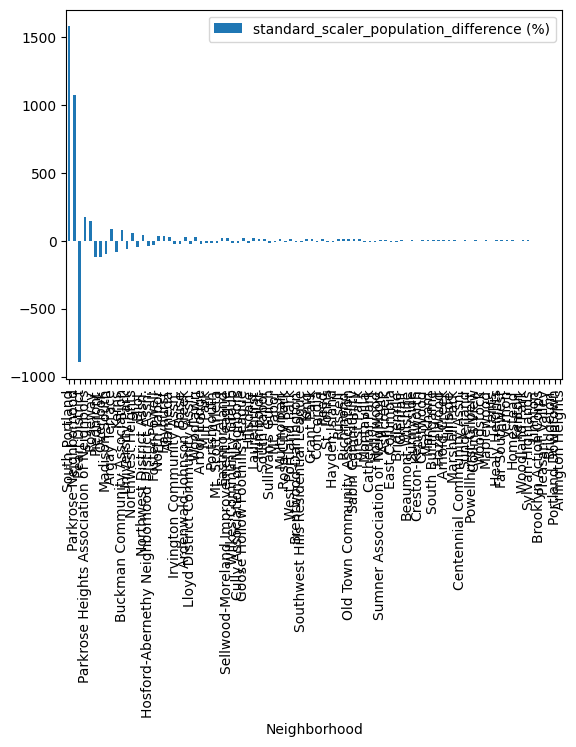

In [27]:
neighborhood_populations[['Neighborhood', 'POP10', 'POP20', 'standard_scaler_pop10', 'standard_scaler_pop20', 'standard_scaler_population_difference (%)']].iloc[(-neighborhood_populations['standard_scaler_population_difference (%)'].abs()).argsort()].plot.bar(x='Neighborhood', y ='standard_scaler_population_difference (%)')